# Pokemon Classificator
Workflow d'apprentissage supervisé avec scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

## Project Statement

### Contexte

Les Pokémon sont des créatures aux caractéristiques variées, certaines étant
classées comme "légendaires" en raison de leur rareté et de leur puissance. L’objectif est
d’entraîner un modèle permettant de prédire si un Pokémon est légendaire ou non à
partir de ses statistiques.


### Description des données

Le jeu de données comprend des informations sur 800
Pokémon, incluant des caractéristiques comme les points de vie (HP), l’attaque, la
défense, la vitesse, ainsi que des attributs catégoriels (type, génération, etc.).
Pistes à explorer :
* Sélection des meilleures caractéristiques pour la classification.
* Comparaison des performances des modèles (arbres de décision, kNN, réseaux de
neurones).
* Impact de la normalisation des données sur les résultats.

Lien du jeu de données : https://www.kaggle.com/abcsds/pokemon


## Preprocessing

### Data importation

In [ ]:
pokemon_df = pd.read_csv("Pokemon.csv")
print("Pokemon data set size:", pokemon_df.size)
pokemon_df.head()

Pokemon data set size: 10400


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [ ]:
pokemon_df["Type 1"].unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

In [ ]:
pokemon_df["Type 2"].unique()

array(['Poison', nan, 'Flying', 'Dragon', 'Ground', 'Fairy', 'Grass',
       'Fighting', 'Psychic', 'Steel', 'Ice', 'Rock', 'Dark', 'Water',
       'Electric', 'Fire', 'Ghost', 'Bug', 'Normal'], dtype=object)

### Drop or Clean Irrelevant Columns

Drop unnecesary **#** and **Legendary** columns from the explicit variable, as well as the "Name" since there are too many different ones

\# (index or ID)
Name (string, probably not useful unless you use NLP)

In [ ]:
X = pokemon_df.drop(["#", "Name", "Legendary"], axis=1) # Axis=1 allows to drop columns

### Encode Categorical Features

Use One-Hot Encoding for Type 1 and Type 2.
We could use LabelEncoder, but one-hot is safer for tree-based or NN models.

In [ ]:
X = pd.get_dummies(X)

These are the resulting columns:

In [ ]:
X.columns

Index(['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed',
       'Generation', 'Type 1_Bug', 'Type 1_Dark', 'Type 1_Dragon',
       'Type 1_Electric', 'Type 1_Fairy', 'Type 1_Fighting', 'Type 1_Fire',
       'Type 1_Flying', 'Type 1_Ghost', 'Type 1_Grass', 'Type 1_Ground',
       'Type 1_Ice', 'Type 1_Normal', 'Type 1_Poison', 'Type 1_Psychic',
       'Type 1_Rock', 'Type 1_Steel', 'Type 1_Water', 'Type 2_Bug',
       'Type 2_Dark', 'Type 2_Dragon', 'Type 2_Electric', 'Type 2_Fairy',
       'Type 2_Fighting', 'Type 2_Fire', 'Type 2_Flying', 'Type 2_Ghost',
       'Type 2_Grass', 'Type 2_Ground', 'Type 2_Ice', 'Type 2_Normal',
       'Type 2_Poison', 'Type 2_Psychic', 'Type 2_Rock', 'Type 2_Steel',
       'Type 2_Water'],
      dtype='object')

In [ ]:
y = pokemon_df["Legendary"].astype(int)  # convert True/False to 1/0

### Train/Test

We do the training/testing dataset division before the feature selection, to avoid data leakage.

In [ ]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

### Normalization

In [ ]:
scaler = sk.preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


We scale since some algorithms (like kNN or neural networks) are sensitive to scale.
Note that we scale AFTER dividing, so that there is no info leakage.

## Feature selection

### Main categories of feature selection


> **Filter Methods**

Evaluate each feature independently with target variable. Used in preprocessing phase. Fast and limited.

> **Wrapper Methods**

They use different combination of features and compute relation between these subset features and target variable and based on conclusion addition and removal of features are done.
Slow but better.

> **Embedded Methods**

Combination. Good for only certain cases.

### Feature Selection Method to use:



Given that the dataset is not too big , we can have the luxury of using the more reliable **wrapper** methods.

Also, since we have the answer data, we can use **supervised learning**

We have the following options:
* Fordward selection
* Backward selection
* Recursive elimination


Even though Recursive Elimination is normally better than its greedy counterparts, since it only works well if the model can rank feature importance, it could work with decision trees but not with kNN or with neural networks.

So we can work with backward elimination or fordward selection. Since we have a lot of categorical features that are not very useful by themselves, let's use Fordward Selection.



### Fordward Selection



Here some of the Type_1 columns are taken into account and some aren't. This is ok.

Also, note that we do feature selection over X_train_scaled, not over X or X-train to prevent data leakage.

## Models

First, we set up cross-validation

In [ ]:
def evaluate_model(model, X, y):
    scores = sk.model_selection.cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{model.__class__.__name__} Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
    return scores


### k-Nearest Neighbors

Note: kNN is sensitive to scaling — make sure you scale your features!

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
evaluation_knn = evaluate_model(knn, X_scaled, y)

KNeighborsClassifier Accuracy: 0.9213 (+/- 0.0064)


### Arbres de decision

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
evaluation_tree = evaluate_model(tree, X, y)  # no need to scale

DecisionTreeClassifier Accuracy: 0.9488 (+/- 0.0174)


### Neural networks

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
evaluation_mlp =evaluate_model(mlp, X_scaled, y)

MLPClassifier Accuracy: 0.9138 (+/- 0.0218)


## Metrics & Evaluation


### Train vs Test

### Scores

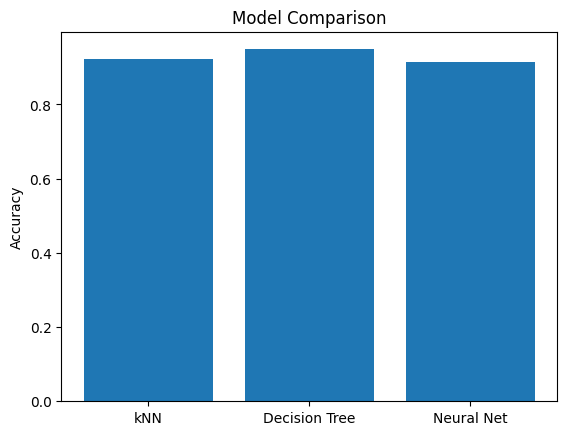

In [ ]:
models = ['kNN', 'Decision Tree', 'Neural Net']

scores = [evaluation_knn.mean(), evaluation_tree.mean(), evaluation_mlp.mean()]
  # Replace with your actual scores

plt.bar(models, scores)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()


Confusion Matrix 


 Classification Report 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       150
           1       0.69      0.90      0.78        10

    accuracy                           0.97       160
   macro avg       0.84      0.94      0.88       160
weighted avg       0.97      0.97      0.97       160



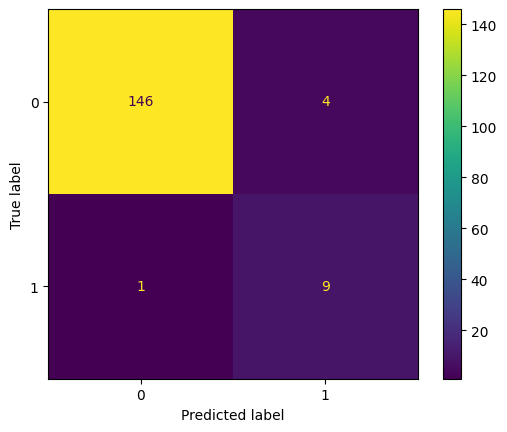

In [ ]:

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
confusion_matrix = sk.metrics.confusion_matrix(y_test, y_pred)
disp = sk.metrics.ConfusionMatrixDisplay(confusion_matrix)
print("Confusion Matrix \n")
disp.plot()
print("\n Classification Report \n", sk.metrics.classification_report(y_test, y_pred))


## To Do:

* Impact de la normalisation des données sur les résultats.
* Comparaison des performances des modèles: HERE
* Est-ce que la selection de features était bien faite? Oui, ca va
* Utilisation IA
* Report